# 95-791 Data Mining (Fall 2021) - Final Project, Part 3
### Name: Jamie Lim, Thomas Tam, Tina Feng

# Question 2: 
If an individual is classified as a potential recidivist, in which year* is he/she likely to recidivate and what features are associated with the difference in arrest years?



For this task, we are only look at a subset of the cleaned dataset: people who recidivated within 3 years (`Recidivism_Within_3years == 1`). We construct a new `Year` variable as our target by encoding `Recidivism_Arrest_Year1`,`Recidivism_Arrest_Year2`,`Recidivism_Arrest_Year3` to a categorical variable with 3 classes (1,2,3). We use the rest variables excluding `Recidivism_Within_3years`,`Recidivism_Arrest_Year1`,`Recidivism_Arrest_Year2`, and `Recidivism_Arrest_Year3` as features. 

Question 2 is a follow-up for Question 1：if an individual is classified as recidivist by the best model from Q1, we would like to predict in which year* the recidivism arrest is likely to occur, and what features are associated with the difference in arrest years. 

This question can be answered with classification models and feature importance. Here we will explore four classification models as follows:
1. K-Nearest Neighbors
    - Suitable for classification tasks
    - Simple & intuitive
    - Inherently multiclass
2. Naive Bayes Classifier
    - Suitable for classification tasks
    - Efficient and not biased by outliers
    - Inherently multiclass
3. Random Forest 
    - Powerful and accurate
    - Support multiclass-multioutput
4. Gradient Boosting
    - Enables a more complex ensemble
    - Support multiclass-multioutput 
    
    
**Year 1 if the recidivism arrest occurred in year 1 after the parole supervision starte date, year 2 if it occurred in year 2, and year 3 if it occurred in year 3.*

In [1]:
# import needed libraries and packages
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import train_test_split,cross_val_score, GridSearchCV
from sklearn import metrics, preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from imblearn.over_sampling import RandomOverSampler 
from sklearn.metrics import roc_auc_score


%matplotlib inline
plt.style.use('seaborn-white')

## 1. Encoding Target Variable

In [2]:
# read csv file
df_cleaned = pd.read_csv('df_cleaned.csv')
# filter so we only look at recidivists
df_cleaned_r = df_cleaned[df_cleaned['Recidivism_Within_3years']==1].copy()

In [3]:
# check if three classes are balanced
n_year1 = len(df_cleaned_r[df_cleaned_r['Recidivism_Arrest_Year1']==1])
n_year2 = len(df_cleaned_r[df_cleaned_r['Recidivism_Arrest_Year2']==1])
n_year3 = len(df_cleaned_r[df_cleaned_r['Recidivism_Arrest_Year3']==1])
n_total = len(df_cleaned_r)

print(f'Cases in Arrest Year 1: {n_year1}, {n_year1 / n_total * 100:.2f}%')
print(f'Cases in Arrest Year 2: {n_year2}, {n_year2 / n_total * 100:.2f}%')
print(f'Cases in Arrest Year 3: {n_year3}, {n_year3 / n_total * 100:.2f}%')

Cases in Arrest Year 1: 7086, 51.64%
Cases in Arrest Year 2: 4212, 30.70%
Cases in Arrest Year 3: 2424, 17.67%


**Comment:** 

Since the three classes we will be using to construct our target variable are not well balanced, we will need to use bootstrapping for oversampling

In [4]:
# construct target variable
# by encoding the three dummy year-variables to one categorical variable with 3 classes: 1, 2, 3  
year = []
for i in range(len(df_cleaned_r)):
    if df_cleaned_r.iloc[i]['Recidivism_Arrest_Year1'] == 1:
        year.append(1)
    elif df_cleaned_r.iloc[i]['Recidivism_Arrest_Year2'] == 1:
        year.append(2)
    elif df_cleaned_r.iloc[i]['Recidivism_Arrest_Year3'] == 1:
        year.append(3)
        

In [5]:
# add the target variable column to dataframe
df_cleaned_r['Year']=year

In [6]:
# drop unneeded columns
df_cleaned_r = df_cleaned_r.drop(columns = ['Recidivism_Within_3years','Recidivism_Arrest_Year1',
                             'Recidivism_Arrest_Year2','Recidivism_Arrest_Year3'])

In [7]:
# take a look at the cleaned dataframe ready for use
df_cleaned_r

,Gender,Race,Age_at_Release,Gang_Affiliated,Supervision_Risk_Score_First,Education_Level,Dependents,Prison_Years,Prior_Arrest_Episodes_Felony,Prior_Arrest_Episodes_Misd,...,Percent_Days_Employed,Jobs_Per_Year,Employment_Exempt,Supervision_Level_First_High,Supervision_Level_First_Standard,Prison_Offense_Drug,Prison_Offense_Property,Prison_Offense_Violent/Non-Sex,Prison_Offense_Violent/Sex,Year
1,1.0,0.0,3.0,0.0,5.0,0.0,1.0,3.0,8.0,6.0,...,0.425234,2.000000,0.0,0.0,0.0,0.0,0.0,1.0,0.0,3
2,1.0,0.0,6.0,0.0,6.0,2.0,3.0,1.0,7.0,6.0,...,0.000000,0.000000,0.0,1.0,0.0,1.0,0.0,0.0,0.0,2
4,1.0,1.0,3.0,0.0,3.0,0.0,3.0,1.0,5.0,4.0,...,0.203562,0.929389,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1
6,1.0,0.0,6.0,0.0,1.0,0.0,2.0,0.0,2.0,6.0,...,0.000000,0.000000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,3
8,0.0,0.0,5.0,0.0,6.0,1.0,0.0,0.0,2.0,4.0,...,0.000000,0.000000,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23155,1.0,1.0,5.0,0.0,4.0,2.0,3.0,3.0,0.0,0.0,...,0.000000,0.000000,1.0,0.0,1.0,0.0,0.0,0.0,0.0,2
23156,1.0,0.0,1.0,0.0,4.0,2.0,1.0,3.0,3.0,2.0,...,0.189507,0.572044,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1
23157,1.0,1.0,4.0,0.0,4.0,2.0,3.0,3.0,0.0,2.0,...,0.757098,0.576104,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2
23158,1.0,0.0,3.0,0.0,4.0,2.0,3.0,3.0,0.0,0.0,...,0.711138,0.894125,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2


In [8]:
# get X and y
X = df_cleaned_r.drop(['Year'], axis=1)
y = df_cleaned_r['Year']

In [9]:
# do oversampling to address the issue of unbalanced classes
ros = RandomOverSampler(random_state=0)
X_res, y_res = ros.fit_resample(X, y)

# check if classes are balanced after oversampling
# yes, they are!
print('After oversampling:')
print(f'Cases in Arrest Year 1: {sum(y_res==1)}, {sum(y_res==1) / len(y_res)*100:.2f}%')
print(f'Cases in Arrest Year 2: {sum(y_res==2)}, {sum(y_res==2) / len(y_res)*100:.2f}%')
print(f'Cases in Arrest Year 3: {sum(y_res==3)}, {sum(y_res==3) / len(y_res)*100:.2f}%')

After oversampling:
Cases in Arrest Year 1: 7086, 33.33%
Cases in Arrest Year 2: 7086, 33.33%
Cases in Arrest Year 3: 7086, 33.33%


## 2. Model Selection

In [10]:
# split train and test dataset
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=0)

### 2.1 K-Nearest Neighbors

In [11]:
# tuning parameter k
# create holder for cv errors
knn_cverrs = {}
# create KNN model object
knn = KNeighborsClassifier()
# loop over k from 1 to 29
for i in range(1,30):
    knn.set_params(n_neighbors=i)
    # get cv error for each k and store it
    CV_error = np.mean(cross_val_score(knn, X_train, y_train, cv=5))
    knn_cverrs[i] = CV_error
# choose the best k by minimum cv error
k_best = min(knn_cverrs, key=knn_cverrs.get)

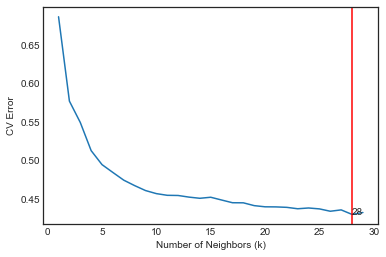

In [12]:
# plot CV error vs Number of neighbors
plt.plot(range(1,30),[val for i,val in knn_cverrs.items()])
plt.xlabel("Number of Neighbors (k)")
plt.ylabel("CV Error")
plt.axvline(x = k_best,color='r')
plt.text(x=k_best,y=min([i for k,i in knn_cverrs.items()]),s=k_best)
plt.show()

In [13]:
# create KNN classifier and fit it using training data
knn = KNeighborsClassifier(n_neighbors=k_best).fit(X_train, y_train)
# get predicted target by applying the KNN model to test data
y_pred = knn.predict(X_test)

# generate and plot confusion matrix
cm_knn = confusion_matrix(y_test,y_pred)
display_cm = ConfusionMatrixDisplay(confusion_matrix=cm_knn, display_labels=['Year1','Year2','Year3'])

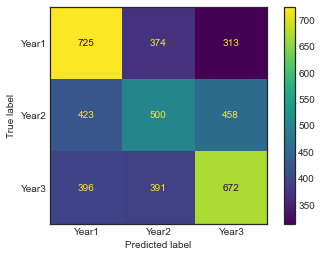

In [14]:
display_cm.plot()

In [15]:
# print classification report
print(classification_report(y_test, y_pred, digits=3))

              precision    recall  f1-score   support

           1      0.470     0.513     0.491      1412
           2      0.395     0.362     0.378      1381
           3      0.466     0.461     0.463      1459

    accuracy                          0.446      4252
   macro avg      0.444     0.445     0.444      4252
weighted avg      0.444     0.446     0.445      4252



**Comment:** 

KNN model has an accuracy of 0.446 and this model performs badly in classifying all three classes

### 2.2 Naive Bayes Classifier

In [16]:
# set Naive Bayes classifier
NB = GaussianNB()
# fit the classifier using training data
NB.fit(X_train, y_train)
# predict target using the model fit
NB_pred = NB.predict(X_test)
# generate and plot confusion matrix
cm_NB = confusion_matrix(y_test, NB_pred)
display_cm_NB = ConfusionMatrixDisplay(confusion_matrix = cm_NB, display_labels=['Year1','Year2','Year3'])
    

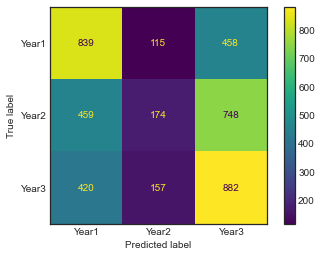

In [17]:
display_cm_NB.plot()

In [18]:
# print classification report
print(classification_report(y_test, NB_pred, digits=3))

              precision    recall  f1-score   support

           1      0.488     0.594     0.536      1412
           2      0.390     0.126     0.190      1381
           3      0.422     0.605     0.497      1459

    accuracy                          0.446      4252
   macro avg      0.434     0.442     0.408      4252
weighted avg      0.434     0.446     0.411      4252



**Comment:** 

Naive Bayes Classifier has an accuracy of 0.446 and this model performs badly in classifying all three classes

### 2.3 Random Forest

In [19]:
# create random forest object
rf = RandomForestClassifier(random_state=0)
# use GridSearchCV to tune hyperparameter for random forest
# Here we include max_features = None for include bagging as one potential model
rf_gs = GridSearchCV(rf,param_grid={'n_estimators':range(500,1001, 100), 'max_features':[None,'sqrt','log2']}) 
rf_gs.fit(X_train, y_train)
# get the best parameters
rf_gs.best_params_

{'max_features': None, 'n_estimators': 800}

In [20]:
# refit the random forest model using the best hyperparameters
# since the best max_features heer is None, it's essentially bagging tree
rf = RandomForestClassifier(n_estimators = 600, max_features = None, random_state=0)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)
# generate and plot confusion matrix
cm_rf = confusion_matrix(y_test, rf_pred)
display_cm_rf = ConfusionMatrixDisplay(confusion_matrix = cm_rf, display_labels=['Year1','Year2','Year3'])
                           


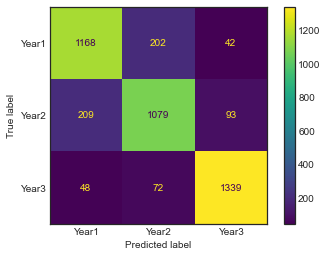

In [21]:
display_cm_rf.plot()   

In [22]:
# print classification report
print(classification_report(y_test, rf_pred, digits=3))

              precision    recall  f1-score   support

           1      0.820     0.827     0.823      1412
           2      0.797     0.781     0.789      1381
           3      0.908     0.918     0.913      1459

    accuracy                          0.843      4252
   macro avg      0.842     0.842     0.842      4252
weighted avg      0.843     0.843     0.843      4252



**Comment:** 

Random Forest Model (in this case, Bagging Tree Model) has an accuracy of 0.843 and this model performs well in classifying all three classes

### 2.4 Gradient Boost

In [23]:
# create gradient boosting classifier object
gb_clf = GradientBoostingClassifier(random_state=0)
# use GridSearchCV to tune hyperparameter for gradient boosting
params = {'n_estimators':[100,500], 'learning_rate':[0.05, 0.1]}
gb_gs = GridSearchCV(gb_clf, param_grid=params)
gb_gs.fit(X_train, y_train)
# get the best parameters
gb_gs.best_params_

{'learning_rate': 0.1, 'n_estimators': 500}

In [24]:
# refit the gradient boosting classifier using best parameters
gb_clf = GradientBoostingClassifier(learning_rate=0.05,n_estimators=100, random_state=0)
gb_clf.fit(X_train, y_train)
gb_pred = gb_clf.predict(X_test)
# generate and plot confusion matrix
cm_gb = confusion_matrix(y_test, gb_pred)
display_cm_gb = ConfusionMatrixDisplay(confusion_matrix = cm_gb, display_labels=['Year1','Year2','Year3'])
                             


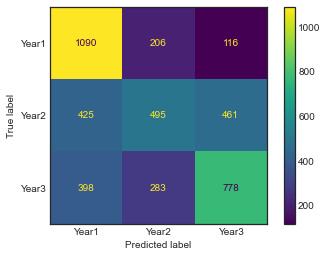

In [25]:
display_cm_gb.plot() 

In [26]:
# print classification result
print(classification_report(y_test, gb_pred, digits=3))

              precision    recall  f1-score   support

           1      0.570     0.772     0.656      1412
           2      0.503     0.358     0.419      1381
           3      0.574     0.533     0.553      1459

    accuracy                          0.556      4252
   macro avg      0.549     0.555     0.542      4252
weighted avg      0.550     0.556     0.543      4252



**Comment:** 

Gradient Boosting Model has an accuracy of 0.556 and this model performs relatively better in classifying class 1 (depspite low precision)

## 3. Model Validation
- Use ROC_AUC Score

In [27]:
print('1. kNN:\nAUC = ', roc_auc_score(y_test, knn.predict_proba(X_test), multi_class='ovr'),'\n')
print('2. Naive Bayes:\nAUC = ', roc_auc_score(y_test, NB.predict_proba(X_test), multi_class='ovr'),'\n')
print('3. Random Forest (Bagging here):\nAUC = ', roc_auc_score(y_test, rf.predict_proba(X_test), multi_class='ovr'),'\n')
print('4. Gradient Boosting:\nAUC = ', roc_auc_score(y_test, gb_clf.predict_proba(X_test), multi_class='ovr'),'\n')

1. kNN:
AUC =  0.6315867504791256 

2. Naive Bayes:
AUC =  0.6231483133652495 

3. Random Forest (Bagging here):
AUC =  0.9541259066162612 

4. Gradient Boosting:
AUC =  0.7435403530599372 



- **AUC: Area Under The Curve**
    - Measure the area under the ROC curve
    - Computation of the relationship between false positives and true positives.
    - Ranges from 0 to 1
    - The worst case would be a random classifier with AUC = 0.5 (diagonal)
    - "As a rule of thumb, an AUC above 0.85 means high classification accuracy, one between 0.75 and 0.85 moderate accuracy, and one less than 0.75 low accuracy" (D' Agostino, Rodgers, & Mauck, 2018)


- **Ideal Case**
    - The larger the AUC (closer to 1), the better the classifier

    
- **Model Evaluation**
    - Among the 4 classification models, the Random Forest model (Bagging tree model here) yields the highest AUC of 0.954, which is considered to have high classification accuracy, so we pick it as the best model


## 4. Best Model Performance

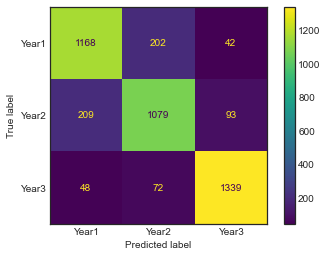

In [28]:
# Get confusion matrix of random forest(bagging)
display_cm_rf.plot()  

In [29]:
# print classification report
print(classification_report(y_test, rf_pred, digits=3))

              precision    recall  f1-score   support

           1      0.820     0.827     0.823      1412
           2      0.797     0.781     0.789      1381
           3      0.908     0.918     0.913      1459

    accuracy                          0.843      4252
   macro avg      0.842     0.842     0.842      4252
weighted avg      0.843     0.843     0.843      4252



### 4.1 Interpretation of Classification Results from the Best Model

- The overall accuracy of our best model (Bagging Tree Model) is 84.3%. It also generates both high precision and recall (around or higher than 80%) for all three classes (Arrest Year 1, Arrest Year 2, and Arrest Year 3). 
- Specifically, the model has the best performance in classifying class 3 (Arrest Year 3).

## 5. Feature Importance 

In [30]:
# plot feature importance plot
feature_df = pd.concat([pd.Series(X_train.columns), pd.DataFrame(rf.feature_importances_)], axis=1)
feature_df.columns = ['Feature', 'Mean Decrease in Impurity']
feature_df.sort_values(by = ['Mean Decrease in Impurity'], inplace=True)

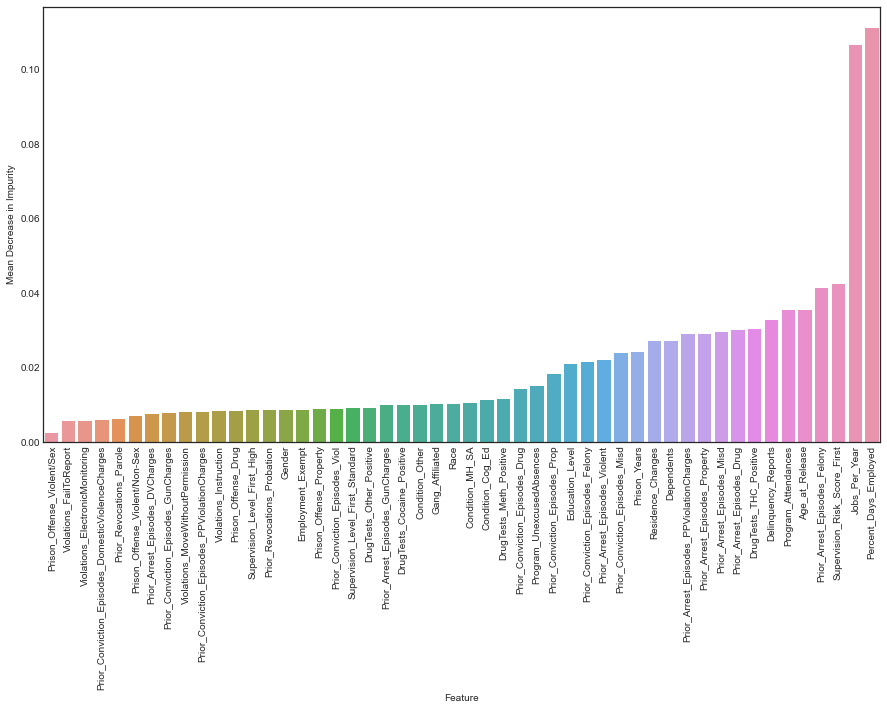

In [31]:
plt.figure(figsize=(15, 8))
plt.xticks(rotation=90)
sns.barplot(x= 'Feature', y= 'Mean Decrease in Impurity', data=feature_df)
plt.show()

## Answer to Q2

To predict a potential recidivist's arrest year and determine the main features associated with the difference in arrest years, we explored 4 different classification models. Among them, we chose the Bagging Tree model as our best model as it yielded the highest AUC of 0.954.


| TOP 7 important features in predicting the arrest year (Q2) |  TOP 7 important features in predicting recidivism (Q1)| 
| --- | --- |
| Percent days employeed | Percent days employeed 
| Jobs per year| Jobs per year
| Supervision risk score first | Prior arrest episodes PPViolationCharges | 
| Prior arrest episodes felony | Age at released | 
| Age at released | Gang affiliated |
| Program attendances | Supervision risk score first |
| Delinquency reports| Prior arrest episodes felony |


Comparison of TOP 7 important features in Q1 and Q2:

(Classification model for recidivism  vs Classification model for arrest years)

- Percent days employeed and jobs per year are the TOP 1 and TOP 2 important features for both models
- Age at released, prior arrest episodes felony, and supervision risk score first are considered important for both models, but with different importance levels
- Only 2 out of 7 most important features in total are not shared by both models
    - Prior arrest episodes PPViolationCharges and Gang affiliated are associated with predicting recidivism
    - Program attendances, Delinquency reports are associated with predicting the arrest year

# References
- ISLR - Chapter 4: Classification Methods
- ISLR - Chapter 8: Tree-Based Methods
- ISLR - Chapter 5: Resampling Methods
- Homework 2
- Homework 3
- [Classification models for multiclasses](https://scikit-learn.org/stable/modules/multiclass.html)
- [ROC AUC score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html)
- [RandomOverSampler](https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.RandomOverSampler.html)